In [5]:
! pip install --quiet fuzzywuzzy

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
from validation.data import indeed_test_data, dot_train_data, get_soc_n
from statsmodels.iolib.summary2 import _df_to_simpletable

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 4]
plt.rcParams['savefig.dpi'] = 300

In [2]:
rel = lambda x: x/x.sum()

def format_bls(path):
    bls = pd.read_csv(path, sep='\t')
    bls = bls.dropna(subset = ['soc2000'])
    bls['soc3'] = bls['soc2000'].map(lambda x: str(int(x))[:3]).astype(int)
    bls = bls.rename(columns = { 'soc3': 'soc-3'})
    bls_dat = rel(bls.groupby('soc-3').sum().tot_emp)
    bls_lookup = bls.groupby('soc-3').head(1)
    df = pd.DataFrame({'share': bls_dat})
    return df, bls_lookup

def format_predicted(path):
    predictions = pd.read_csv(path)
    predicted_dat = rel(predictions.predicted_soc3.value_counts())
    df = pd.DataFrame(predicted_dat)
    df.index = df.index.rename('soc-3')
    return df.rename(columns = {'predicted_soc3': 'share'}).sort_values('soc-3')

def format_matched_dat(path):
    matched = pd.read_csv(path)
    matched['soc3'] = get_soc_n(matched['2000 SOC code'], 3)
    matched_dat = rel(matched.soc3.value_counts()).reset_index()
    s = matched_dat.sort_values('index')
    return matched_dat.rename(columns = {'soc3': 'share', 'index': 'soc-3'}).set_index('soc-3')

In [3]:
bls_dat, bls = format_bls('oes_2014_flat.csv')
matched_dat = format_matched_dat('indeed-us-titles-matched.csv')
predicted_dat = format_predicted('predictions/us-soc3-predictions.csv')

In [4]:
common = set(bls_dat.index) & set(matched_dat.index) & set(predicted_dat.index)

bls_dat, matched_dat, predicted_dat = [df.loc[df.index.isin(common)] for df in 
                                       [bls_dat, matched_dat, predicted_dat]]

In [5]:
predictions = pd.read_csv('predictions/us-soc3-predictions.csv')

In [6]:
from validation.dot_data import get_dictionary

confusion = pd.read_csv('confusion-matrices/soc-3/embed-lr.csv')
dot_codes = get_dictionary('', 3).groupby('soc').first()
confusion.columns = dot_codes.index
confusion.index = dot_codes.index

In [7]:
P = confusion.shape[0]
N = predictions.predicted_soc3.shape[0]
arr = np.ones((N, P))
for i,p in enumerate(predictions.predicted_soc3):
    try:
        arr[i,:] = confusion[p].values
    except KeyError:
        arr[i,:] = np.zeros(P)

In [8]:
# Adjust predicted data by the confusion matrix for prediction over distribution!!

predicted_dat = pd.Series(arr.sum(0) / arr.sum(), 
                          index=confusion.columns, 
                          name='share')[predicted_dat.index].to_frame()

In [9]:
get_code = lambda idx: bls_dat.index.values[idx]
get_idx = lambda code: np.argwhere(bls_dat.reset_index()['soc-3'] == code)[0][0]
get_title = lambda code: dot_codes.desc_soc3.to_dict()[code]

In [10]:
def truncate(s, lim):
    if len(s) > lim:
        return s[0:lim-2] + chr(8230)
    return s

def table(idx, lim=50):
    df = pd.DataFrame({ 'BLS': bls_dat.share, 
                        'Predicted Indeed': predicted_dat.share})
    df = df.iloc[idx].reset_index()
    df['soc-3'] = df['soc-3'].map(get_title)
    df = df.rename(columns = {'soc-3': 'Occupation'})
    df['Occupation'] = df.Occupation.map(lambda s: truncate(s, lim))
    table = _df_to_simpletable(df, float_format='%.3f', index=False)
    return table.as_latex_tabular()

In [11]:
dif = (bls_dat.values - predicted_dat.values).reshape(-1)

In [12]:
# Most overrepresented in Indeed Predictions
print(table(dif.argsort()[:10]))

\begin{center}
\begin{tabular}{ccc}
\hline
                 Occupation                  &  BLS  & Predicted Indeed  \\
\hline
\hline
\end{tabular}
\begin{tabular}{rrr}
                        Computer Occupations & 0.023 &            0.373  \\
                       Financial Specialists & 0.020 &            0.083  \\
             Media and Communication Workers & 0.003 &            0.060  \\
             Business Operations Specialists & 0.025 &            0.061  \\
Health Diagnosing and Treating Practitioners & 0.036 &            0.057  \\
        Other Healthcare Support Occupations & 0.010 &            0.029  \\
                Other Management Occupations & 0.016 &            0.035  \\
                                   Engineers & 0.012 &            0.030  \\
                      Art and Design Workers & 0.004 &            0.017  \\
             Other Sales and Related Workers & 0.005 &            0.017  \\
\hline
\end{tabular}
\end{center}


In [13]:
# Most underepresented in Indeed Predictions
print(table(np.flip(dif.argsort()[-10:], 0)))

\begin{center}
\begin{tabular}{ccc}
\hline
                    Occupation                    &  BLS  & Predicted Indeed  \\
\hline
\hline
\end{tabular}
\begin{tabular}{rrr}
                             Retail Sales Workers & 0.067 &            0.002  \\
                Food and Beverage Serving Workers & 0.053 &            0.005  \\
                    Information and Record Clerks & 0.042 &            0.013  \\
                          Material Moving Workers & 0.034 &            0.005  \\
                          Motor Vehicle Operators & 0.029 &            0.000  \\
Preschool, Primary, Secondary, and Special Educa… & 0.029 &            0.003  \\
        Secretaries and Administrative Assistants & 0.028 &            0.002  \\
  Other Office and Administrative Support Workers & 0.029 &            0.004  \\
                      Construction Trades Workers & 0.025 &            0.001  \\
       Building Cleaning and Pest Control Workers & 0.024 &            0.001  \\
\hline
\end{tabul

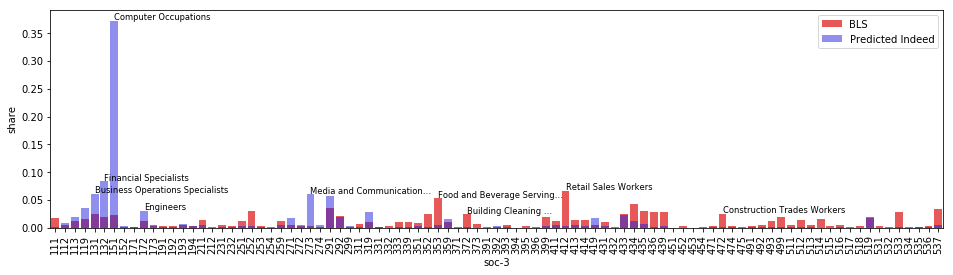

In [17]:
ax = sns.barplot(x='soc-3', y='share', color='red', alpha=.75, label='BLS', data=bls_dat.reset_index())
ax = sns.barplot(x='soc-3', y='share', ax=ax, color='blue', alpha=.5, label='Predicted Indeed', data=predicted_dat.reset_index())
ax.legend()
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

annotations = [131, 132, 151, 172, (273, 25), (353, 27), (372, 20), 412, 472]
# annotations = [151, 172, 291, (353, 27), (372, 20), 412, (439, 41)]

def annotate_barplot(ax, a, b, annotations):
    lookup_a = {idx:r.share for idx,r in a.iterrows()}
    lookup_b = {idx:r.share for idx,r in b.iterrows()}

    for a in annotations:
        try:
            code,lim = a 
        except TypeError:
            code,lim = a, None
        share = lookup_a[code]            
        pred = lookup_b[code]
        idx = get_idx(code)
        title = get_title(code)
        if lim:
            title = truncate(title, lim)

        fontdict = {'size': 'smaller'}
        ax.text(idx, max(share, pred) + 0.002, title, rotation=0, fontdict=fontdict)


annotate_barplot(ax, bls_dat, predicted_dat, annotations)
ax.get_figure().savefig('figures/predicted-vs-BLS-adjusted.png')

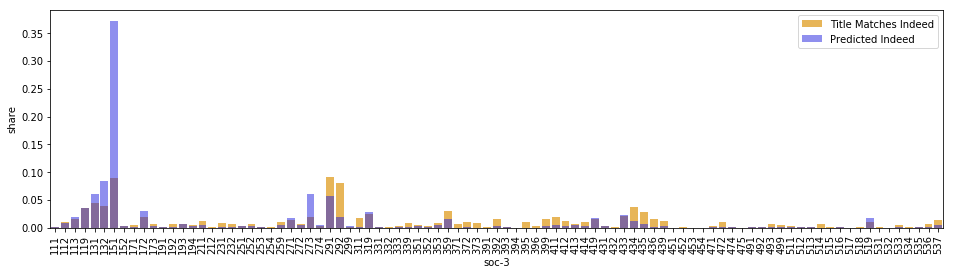

In [19]:
ax = sns.barplot(x='soc-3', y='share', color='orange', alpha=.75, label='Title Matches Indeed', data=matched_dat.reset_index())
ax = sns.barplot(x='soc-3', y='share', ax=ax, color='blue', alpha=.5, label='Predicted Indeed', data=predicted_dat.reset_index())
ax.legend()
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.get_figure().savefig('figures/predicted-vs-exact-match-adjusted.png')

In [6]:
def plot_hist(dat):
    ax = sns.barplot(x = 'soc3', y='share', data = dat.reset_index())
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    return ax

In [7]:
d = pd.concat([bls_dat, matched_dat, predicted_dat], keys = ['BLS', 'Title Matches Indeed', 'Predicted Indeed']).reset_index().rename(columns = {'level_0': 'Source'})

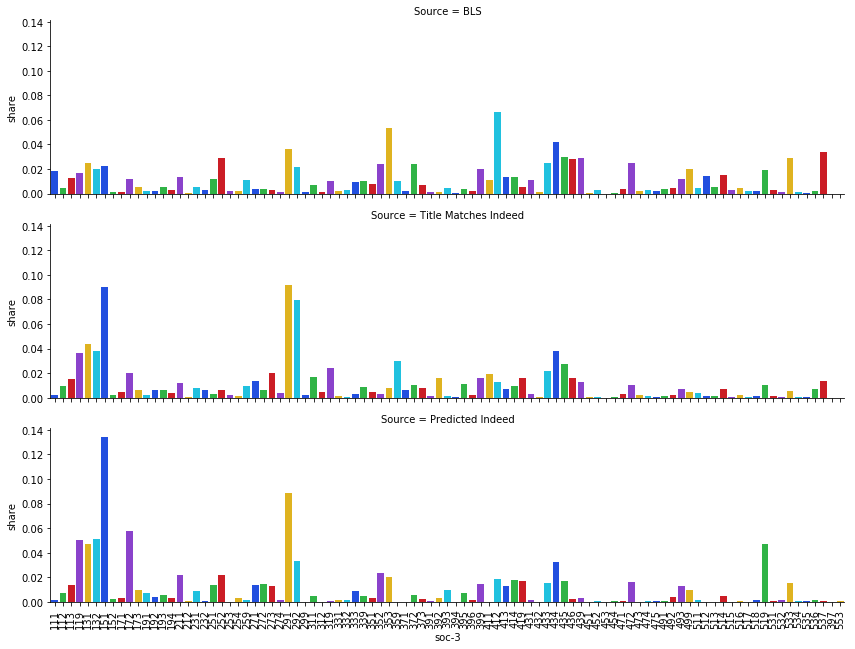

In [12]:
g = sns.FacetGrid(d, row='Source', aspect=4)
codes = d['soc-3'].unique()
ax = g.map(sns.barplot, 'soc-3', 'share', order = codes, palette=sns.palettes.color_palette('bright6', n_colors=len(codes)))
_ = ax.set_xticklabels(codes, rotation=90)
ax.savefig('figures/histograms-compared.png')

In [22]:
from scipy.stats import entropy

entropy(bls_dat.share, predicted_dat.share)

1.4813864556856637

In [ ]:
# get the multinomial distribution predicted for each datapoint
# sample (once) from that multinomial distribution for each datapoint
# repeat this sampling many times
# Those samples give you your posterior predictive of the labor distribution